> Introduction to variations provided in 🤗 [Hugging face](https://huggingface.co/) - [Diffusers library](https://github.com/huggingface/diffusers) such as Negative prompt, Image to Image and training new concept using Textual Inversion





<br>
<div align="center">
  <a href="https://colab.research.google.com/github/prajwal-suresh13/diffusion/blob/master/02_stable_diffusion_variations.ipynb"> <img src=https://colab.research.google.com/assets/colab-badge.svg width=150> </a>
</div> <br>

This is the second post on Stable Diffusion. Check out the previous post through link below if you haven't read it yet
<br><br>
1. **Part 1** - [Stable diffusion - Introduction](https://prajwal-suresh13.github.io/website/posts/2022-11-22-StableDiffusionIntro/01_stable_diffusion_introduction.html).<br>

In previous post, we learnt about Stable Diffusion and its key components VAE, UNet, Scheduler & CLIPTextModel. We also built a pipeline named ```SDPipeline``` using these key components and generated images for multiple prompts. In this post, we will further modify our pipeline to integrate negative prompts and image to image. At the end, we will learn about Textual Inversion which is useful to train a new concept

At first, let's download and import the required libraries, authenticate and login to HuggingFace

In [ ]:
#| code-fold: true
#| output: false
!pip install -Uq accelerate transformers diffusers ftfy

     |████████████████████████████████| 175 kB 7.5 MB/s 
     |████████████████████████████████| 5.5 MB 86.8 MB/s 
     |████████████████████████████████| 434 kB 91.5 MB/s 
     |████████████████████████████████| 53 kB 900 kB/s 
     |████████████████████████████████| 7.6 MB 31.8 MB/s 
     |████████████████████████████████| 182 kB 70.3 MB/s 


In [ ]:
#| code-fold: true
#| output: false
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
#| code-fold: true
import torch
from torch import autocast
from torchvision import transforms as tfms

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
logging.set_verbosity_error() # Suppress unnecessary warning from CLIPTextModel

from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from fastdownload import FastDownload

from IPython.display import HTML
from base64 import b64encode

In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new("RGB", size=(cols*w, rows*h))
    for i, img in enumerate(imgs):grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Below is the pipeline which we built in the previous post using the core components. 

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

In [ ]:
class SDPipeline():
    def __init__(self, model_path):
        self.model_path=model_path
        self.vae = AutoencoderKL.from_pretrained(model_path,subfolder="vae" ,torch_dtype=torch.float16).to(torch_device)
        self.unet=UNet2DConditionModel.from_pretrained(model_path, subfolder="unet", torch_dtype=torch.float16).to(torch_device)
        self.text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder="text_encoder", torch_dtype=torch.float16).to(torch_device)
        self.tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer", torch_dtype=torch.float16)
        self.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

    def encode_text(self, prompts, maxlen=None):
        if maxlen is None: maxlen = self.tokenizer.model_max_length
        inp = self.tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
        return self.text_encoder(inp.input_ids.to(torch_device))[0].half()

    def __call__(self,prompts, guidance=7.5, inference_steps=51, seed=100, callbacks=[], callback_steps=None):
        batch_size = len(prompts)

        cond   = self.encode_text(prompts)
        uncond = self.encode_text([""]*batch_size, cond.shape[1])
        emb    = torch.cat([uncond, cond])
        if seed : torch.manual_seed(seed)

        self.scheduler.set_timesteps(inference_steps)

        latents = torch.randn((batch_size, self.unet.in_channels, 512//8, 512//8))
        latents = latents.to(torch_device).half() * self.scheduler.init_noise_sigma

        for i, t in enumerate(tqdm(self.scheduler.timesteps)):
            inp = self.scheduler.scale_model_input(torch.cat([latents]*2), t)
            with torch.no_grad():u,c = self.unet(inp, t, encoder_hidden_states=emb).sample.chunk(2)
            pred = u + guidance*(c-u)

            latents = self.scheduler.step(pred, t, latents).prev_sample

            if len(callbacks):
                if i%callback_steps==0:
                    for callback in callbacks: callback(i, t, latents)
        
        
        return self.latents_to_pil(latents)



In [ ]:
def create_image(t):
    image = (t/2 +0.5).clamp(0,1).detach().cpu().permute(1,2,0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def pil_to_latents(self,input_img):
    with torch.no_grad():
        latent = tfms.ToTensor()(input_img).unsqueeze(0).to(torch_device)*2-1
        latent = self.vae.encode(latent.half())
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(self, latents):
    latents = (1/0.18215) * latents
    with torch.no_grad():
        images = self.vae.decode(latents).sample
    pil_images =[create_image(image) for image in images]
    return pil_images

SDPipeline.pil_to_latents = pil_to_latents
SDPipeline.latents_to_pil  = latents_to_pil

# Negative Prompts

## What is Negative Prompt? 

Negative prompt is an additional capability which removes anything that the user doesn't want to see in generated images. Suppose you don't want a particular color or particular object to be part of the generated images, you can mention it in ```negative_prompt``` argument in the ```StableDiffusionPipeline```.

<figure align = "center">
<img src="https://miro.medium.com/max/828/0*wnoQYUZJiCwhtUTg.webp" width="800">
    <figcaption align = "center">
        <h4>Fig 1 : Example for Negative Prompt <a href="https://towardsdatascience.com/stable-diffusion-using-hugging-face-variations-of-stable-diffusion-56fd2ab7a265">(Image Credit)</a></h4>
</figcaption>
</figure>

## Adding negative prompt to our SDPipeline

Let's find how the negative prompt works and how can we integrate it into our pipeline.

In the previous post, we used an empty string, generated unconditional embeddings from it and used it along with text embeddings to implement Classifier-Free guidance as below

```
uncond = self.encode_text([""]*batch_size, cond.shape[1])
```

The way negative prompt works is that the empty string is replaced by the string containing the objects, styles or colors provided by the user as negative prompt. So to implement negative prompt, we can modify our code to use empty string if negative prompt is not provided else to use  negative prompt provided by user

```
if not negative_prompts:
    uncond = self.encode_text([""]*batch_size, cond.shape[1])
else:
    uncond = self.encode_text(neg_prompts, cond.shape[1])
```

Let's make those changes in the diffusion loop of our pipeline and check if our negative prompt implementation is working 

In [ ]:
def diff_pipeline_negprompts(self,prompts,negative_prompts=None, guidance=7.5, inference_steps=51, seed=100, callbacks=[], callback_steps=None):
        #calculate number of prompts
        batch_size = len(prompts)
        
        #generate text_embeddings
        cond   = self.encode_text(prompts)
        
        #generate embedding for negative prompts if available else generate unconditional embeddings
        if not negative_prompts: uncond = self.encode_text([""]*batch_size, cond.shape[1])
        else : uncond = self.encode_text(negative_prompts, cond.shape[1])
        emb    = torch.cat([uncond, cond])

        if seed : torch.manual_seed(seed)
        
        #generate random noise and add noise
        latents = torch.randn((batch_size, self.unet.in_channels, 512//8, 512//8))
        
        #Setting number of steps in scheduler
        self.scheduler.set_timesteps(inference_steps)
        
        #Add noise to latents
        latents = latents.to(torch_device).half() * self.scheduler.init_noise_sigma

        for i, t in enumerate(tqdm(self.scheduler.timesteps)):
            # scale the latents for particular timestep
            inp = self.scheduler.scale_model_input(torch.cat([latents]*2), t)
            
            #predict noise using UNet
            with torch.no_grad():u,c = self.unet(inp, t, encoder_hidden_states=emb).sample.chunk(2)
                
            #Perform Classifier-Free Guidance    
            pred = u + guidance*(c-u)
            
            #Removing predicted noise from the latents
            latents = self.scheduler.step(pred, t, latents).prev_sample
            
            #run callbacks if any are added
            if len(callbacks):
                if i%callback_steps==0:
                    for callback in callbacks: callback(i, t, latents)
        
        #after loop is completed, pass the latents to VAE's decoder and return the High-resolution image generated
        return self.latents_to_pil(latents)


In [ ]:
SDPipeline.__call__ = diff_pipeline_negprompts

We will generate two images with same prompt and for one of the images we will use a negative prompt

In [ ]:
pipe = SDPipeline("CompVis/stable-diffusion-v1-4")

In [ ]:
torch.manual_seed(9000)
img1 = pipe(prompts=["a photo of a forest with trees and bushes"])[0]
img2 = pipe(prompts=["a photo of a forest with trees and bushes"], negative_prompts=["green"])[0]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

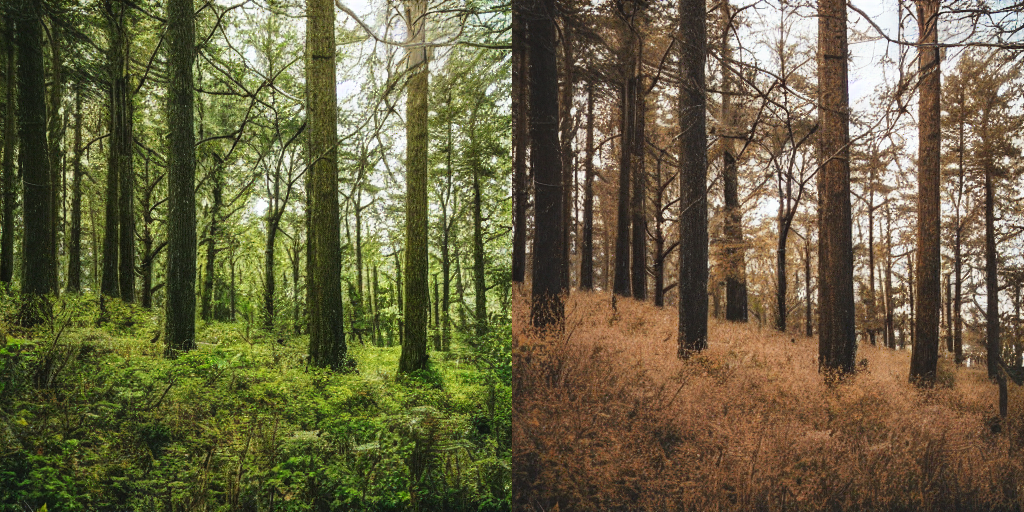

In [ ]:
#| fig-align: center
imgs=[img1, img2]
image_grid(imgs, rows=1, cols=2)

<figcaption align = "center">
        <h4>Fig 2: Negative Prompt Results for prompt "a photo of a forest with trees and bushes" and negative prompt="green""</h4>
</figcaption>

As you can see in the images above, the image on the left generated image of forest. When given negative prompt as color green, the model generated same image without green color in it (on the right)

# Image To Image

## Adding Image to Image capability to SDPipeline

In the previous post, we learnt that we can also pass an image to our model and it generates new images using the provided image as the initial image along with the prompt. There are two scenarios 1) with image (Image to Image) 2) without image (Prompt to Image)

For scenario 1 which is Image to Image pipeline, we expect 2 parameters:<br>
1. ```init_image``` - This is used as the initial image<br>
2. ```strength``` - The value of this parameter is between 0 and 1<br>

First, the provided init_image is passed to the VAE's encoder to generate latents. We then need to add noise to the latents. Since we are using initial image we can reduce the number of inference steps. The ```strength``` parameter is used for this and higher its value higher the ```inference_steps```. If we want our generated image to be similar to the init_image, the number of steps should be less so the ```strength``` parameter value should also be less. The amount of noise to be added is calculated by multiplying the ```strength``` and ```inference_steps```

For example, suppose we want our generated image to be similar to the initial image so we assign  the ```strength``` parameter to 0.4 and ```inference_steps``` is equal to 50 . Then the noise added is for the step 30 (```50 -( 0.4 x 50) == 30```). The ```inference_steps``` is reduced to 20 steps (```50x0.4```)

For scenario 2 which is prompt to image, we need to create a random noise. The amount of noise for the first step is multiplied with ```scheduler.init_noise_sigma``` . The ```inference_steps``` remains same.

Let's create a function which can handle both the scenarios. The function should return latents and timesteps. <br>
1. In case of Prompt to Image, random noise is created and multiplied with init_noise is returned. The timesteps is returned without modifying it<br>
2. In case of Image to Image, latents are created from init_image and amount of noise to be added is calculated using strength and returned. The timesteps is also reduced based on the strength and returned

In [ ]:
def create_latents(self, batch_size, init_image, strength, inference_steps):
    
    if init_image is None:
        latents = torch.randn((batch_size, self.unet.in_channels, 512//8, 512//8))
        latents = latents.to(torch_device).half() * self.scheduler.init_noise_sigma
        return latents, self.scheduler.timesteps.to(torch_device)
    else:
        img_latents = self.pil_to_latents(init_image)
        noise = torch.randn(img_latents.shape, generator=None, device=torch_device, dtype=img_latents.dtype)

        init_timestep = int(inference_steps * strength)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps], device=torch_device)

        init_latents = self.scheduler.add_noise(img_latents, noise, timesteps)

        t_start = max(inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:].to(torch_device)
        
        return init_latents, timesteps

SDPipeline.create_latents = create_latents

Let's replace the diffusion loop code to get latents and timesteps from the above function

In [ ]:
def diff_pipeline_img2img(self,prompts,init_image=None, strength=0.8, negative_prompts=None, guidance=7.5, inference_steps=51, seed=100, callbacks=[], callback_steps=None):
        #calculate number of prompts
        batch_size = len(prompts)
        
        #generate text_embeddings
        cond   = self.encode_text(prompts)
        
        #generate embedding for negative prompts if available else generate unconditional embeddings
        if not negative_prompts: uncond = self.encode_text([""]*batch_size, cond.shape[1])
        else : uncond = self.encode_text(negative_prompts, cond.shape[1])
        emb    = torch.cat([uncond, cond])
        
        if seed : torch.manual_seed(seed)

        #Setting number of steps in scheduler
        self.scheduler.set_timesteps(inference_steps)
        
        #generate random noise and add noise
        latents, timesteps = self.create_latents(batch_size, init_image, strength, inference_steps)
        
        
        for i, t in enumerate(tqdm(timesteps)):
            # scale the latents for particular timestep
            inp = self.scheduler.scale_model_input(torch.cat([latents]*2), t)
            
            #predict noise using UNet
            with torch.no_grad():u,c = self.unet(inp, t, encoder_hidden_states=emb).sample.chunk(2)
                
            #Perform Classifier-Free Guidance    
            pred = u + guidance*(c-u)
            
            #Removing predicted noise from the latents
            latents = self.scheduler.step(pred, t, latents).prev_sample
            
            #run callbacks if any are added
            if len(callbacks):
                if i%callback_steps==0:
                    for callback in callbacks: callback(i, t, latents)
        
        #after loop is completed, pass the latents to VAE's decoder and return the High-resolution image generated
        return self.latents_to_pil(latents)

SDPipeline.__call__ = diff_pipeline_img2img

Now let's download an image and pass it to our Image To Image pipeline

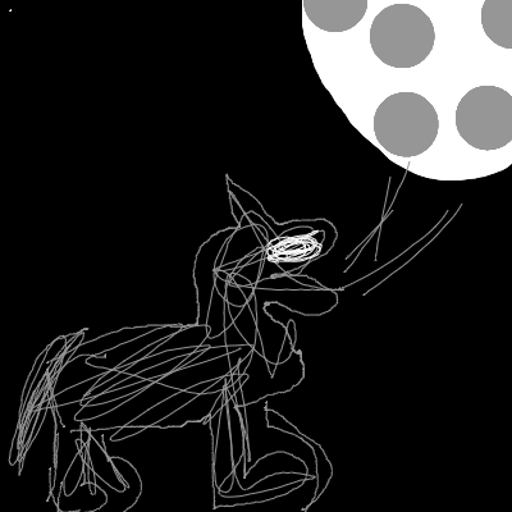

In [ ]:
#| fig-align: center
from fastdownload import FastDownload
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
image = Image.open(p).convert('RGB').resize((512,512))
image

<figcaption align = "center">
        <h4>Fig 3: Initial Image for Image To Image Pipeline</h4>
</figcaption>

We can also add our Callback function to visualize how the image is generated

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",subfolder="vae" ,torch_dtype=torch.float16).to(torch_device)
class Latents_Callback:
    def __init__(self, prompts):
        self.imgs = [[] for _ in range(len(prompts))]
    
    def __call__(self, i, t, latents):
        latents = 1 / 0.18215 * latents
        for i in range(latents.shape[0]):
            callback_imgs = vae.decode(latents).sample[i]
            callback_imgs = create_image(callback_imgs)
            self.imgs[i].append(callback_imgs)

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

We are using a random sketch of wolf howling at moon as initial image. So we can use higher value of strength to generate good image

In [ ]:
prompt = ["Wolf howling at the moon, photorealistic 4K"]
pipei2i = SDPipeline("CompVis/stable-diffusion-v1-4")

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?it/s]

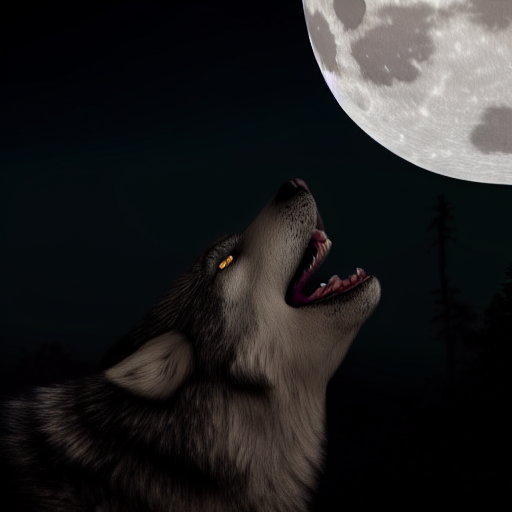

In [ ]:
#| fig-align: center
lc = Latents_Callback(prompt)
img = pipei2i(prompt,init_image=image, callbacks=[lc], callback_steps=8,inference_steps=50)
img[0]

<figcaption align = "center">
        <h4>Fig 4: Generated Image for Image To Image pipeline</h4>
</figcaption>

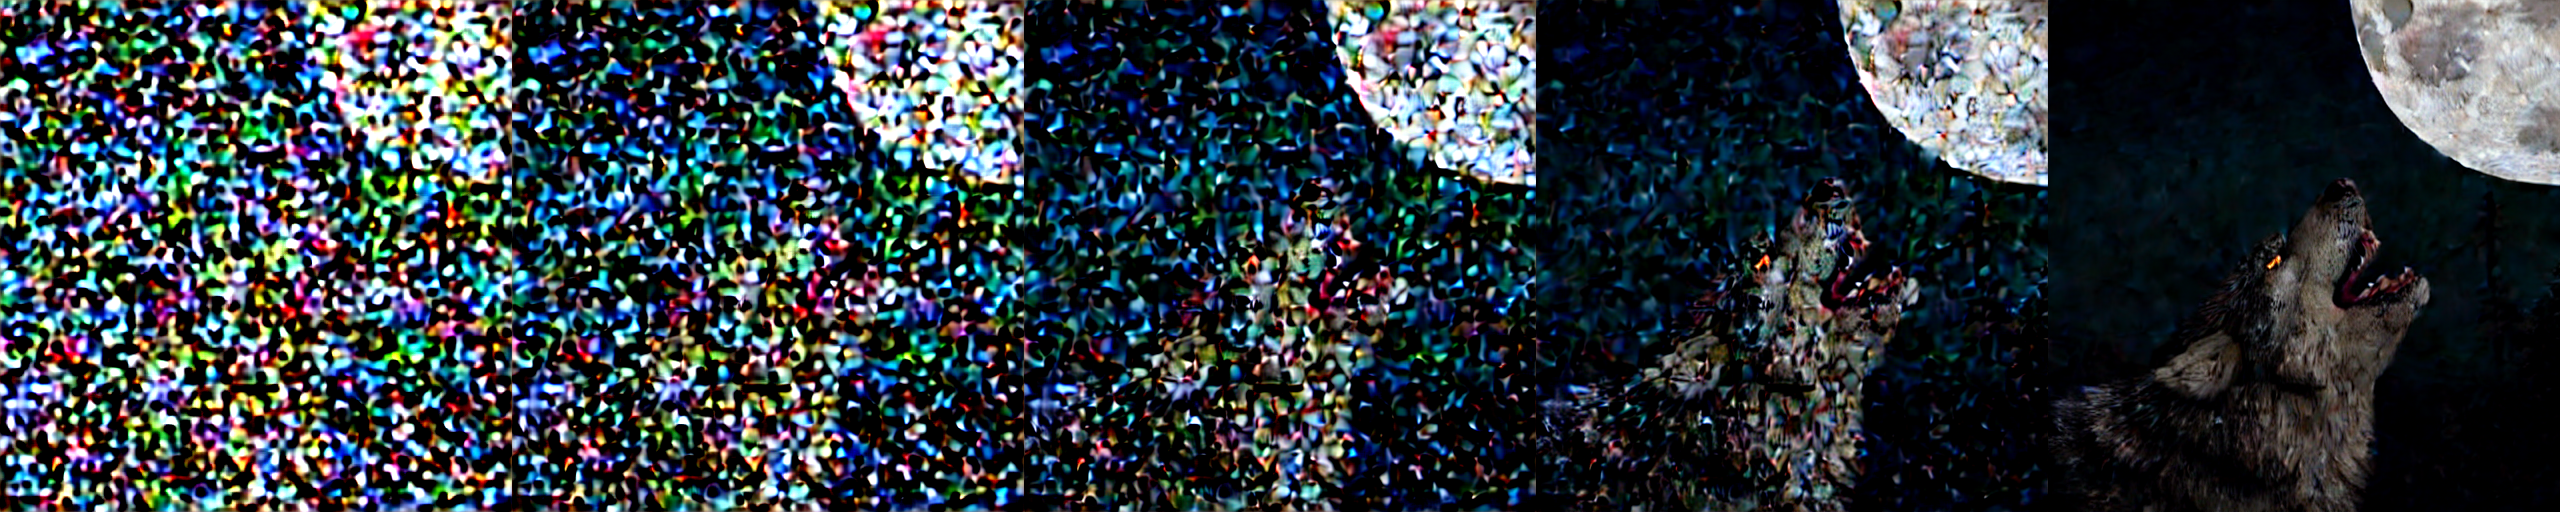

In [ ]:
rows, cols = len(prompt), len(lc.imgs[0])
imgs =[img for i in range(len(prompt)) for img in lc.imgs[i]]
image_grid(imgs, rows=rows, cols=cols)

# Using both Image to Image and Negative Prompt

Let's use both Image to Image and Negative prompt in the next example. We will download a picture of sunflower vase and pass it to Image to Image pipeline to convert it to a Rose vase. 
We will remove yellow color from the generated image using negative prompt

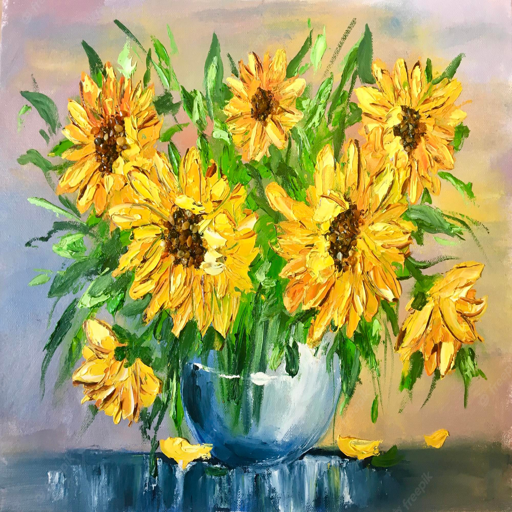

In [ ]:
#| fig-align: center
from fastdownload import FastDownload
p = FastDownload().download('https://img.freepik.com/premium-photo/oil-painting-yellow-flowers-sunflowers-vase-yellow-oil-paints_175677-2889.jpg?w=2000')
image = Image.open(p).convert('RGB').resize((512,512))
image

<figcaption align = "center">
        <h4>Fig 5: Initial Image of Sunflower vase</h4>
</figcaption>

  0%|          | 0/30 [00:00<?, ?it/s]

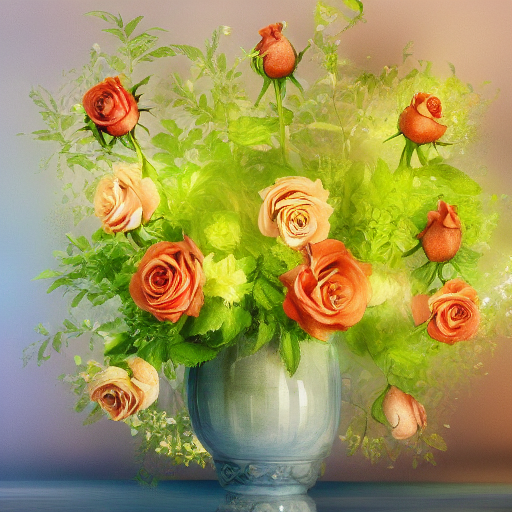

In [ ]:
#| fig-align: center
prompt = ["A photo of a rose flower vase, photorealistic 4K"]
negative_prompts = ['yellow, lowres, worst quality, low quality']
img = pipei2i(prompt, negative_prompts=negative_prompts,init_image=image,inference_steps=50, strength=0.6)
img[0]

<figcaption align = "center">
        <h4>Fig 6: Generated Image of Rose vase for initial image of sunflower vase and Negative Prompt as yellow</h4>
</figcaption>

Until now, we saw how we can use StableDiffusion to generate realistic images based on prompts. But what if we want to generate images for objects or person which the model has never seen. What if we want to generate our own images based on prompt. This can be done using process such as Textual Inversion and Dreambooth. Let's learn about Textual inversion in the next section

# Textual Inversion

Textual Inversion is a process to teach a new word to the text model and get its embeddings close to the visual representation of the image. This is achieved by adding a new token to the vocabulary, freezing the weights of all the models except the text encoder and train with the images. 

This is a schematic representation of the process by the authors of the [Textual Inversion paper](https://textual-inversion.github.io/) 

<figure align = "center">
<img src="https://textual-inversion.github.io/static/images/training/training.JPG" width="800">
    <figcaption align = "center">
        <h4>Fig 7 : Textual Inversion diagram <a href="https://textual-inversion.github.io/">(Image Credit)</a></h4>
</figcaption>
</figure>

We will be implementing Dreambooth in the next post which is similar to Textual Inversion. So we will use an already trained token using Textual Inversion and use it in inference. You can train your own tokens with photos you provide using [this training script](https://github.com/huggingface/diffusers/tree/main/examples/textual_inversion) or [Google Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

We'll try an example using embeddings trained for [this style](https://huggingface.co/sd-concepts-library/indian-watercolor-portraits).

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16) 
pipe = pipe.to(torch_device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Let's download the embedding for the watercolor portrait style 

In [ ]:
embeds_url = "https://huggingface.co/sd-concepts-library/indian-watercolor-portraits/resolve/main/learned_embeds.bin"
embeds_path = FastDownload().download(embeds_url)
embeds_dict = torch.load(str(embeds_path), map_location="cpu")

In [ ]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
new_token, embeds = next(iter(embeds_dict.items()))
embeds = embeds.to(text_encoder.dtype)
new_token, embeds.shape

('<watercolor-portrait>', torch.Size([768]))

We can add the new token which in our case is ```<watercolor-portrait>``` to the tokenizer. We also resize the token embedding of text_encoder and add the embeddings of the ```<watercolor-portrait>``` to the text_encoder

In [ ]:
assert tokenizer.add_tokens(new_token) == 1, "The token already exists!"

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds

We can then use the new token in the prompt to generate images

  0%|          | 0/51 [00:00<?, ?it/s]

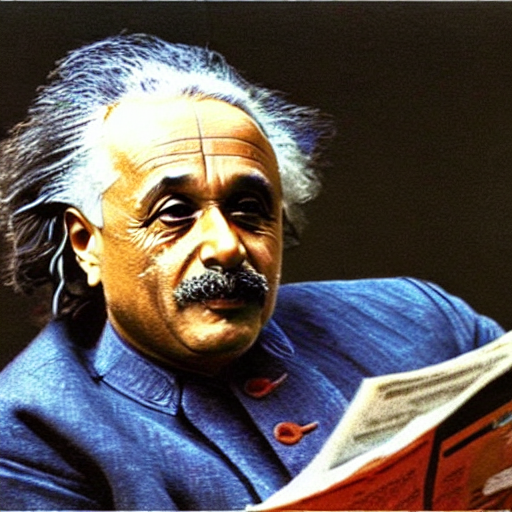

In [ ]:
#| fig-align: center
torch.manual_seed(1000)
image = pipe("Einstein reading newspaper in the style of <watercolor-portrait>").images[0]
image

<figcaption align = "center">
        <h4>Fig 8: Using new token generated using Textual Inversion in prompt</h4>
</figcaption>

# Conclusion

In this post, we have covered a brief introduction on variation provided by the diffusers library such as negative prompt and Image To Image. We then implemented both in our ```SDPipeline```. We also saw how we can train a new concept using Textual Inversion. In the [next post](https://prajwal-suresh13.github.io/website/posts/2022-12-01-Dreambooth/03_pintu_dreambooth.html) we will be learning about Dreambooth which is used to train a new concept and push our trained model to HuggingFace Hub

I hope you enjoyed reading it. If there is any feedback, feel free to reach out on [LinkedIn](https://www.linkedin.com/in/prajwal-s-1416061b3/) or on [mail](mailto:prajwalsuresh13@gmail.com)

# References

- [FastAI course](https://www.fast.ai/posts/part2-2022-preview.html)
- [Aayush Agrawal's blog](https://aayushmnit.com/blog.html)